# Sklonowanie i wejście do repozytorium



In [1]:
!git clone https://github.com/shizzeer/credo-classifier.git

Cloning into 'credo-classifier'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 3), reused 8 (delta 1), pack-reused 0
Receiving objects: 100% (15/15), 5.11 MiB | 9.81 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
%cd credo-classifier

/content/credo-classifier


# Rozpakowanie danych treningowych

In [4]:
!unzip images.zip

Archive:  images.zip
   creating: images/
   creating: images/artefacts/
 extracting: images/artefacts/10219929.png  
 extracting: images/artefacts/10219931.png  
 extracting: images/artefacts/10223942.png  
 extracting: images/artefacts/10228003.png  
 extracting: images/artefacts/10231268.png  
 extracting: images/artefacts/10231560.png  
 extracting: images/artefacts/10232861.png  
 extracting: images/artefacts/10233802.png  
 extracting: images/artefacts/10235049.png  
 extracting: images/artefacts/10235948.png  
 extracting: images/artefacts/10245995.png  
 extracting: images/artefacts/10259097.png  
 extracting: images/artefacts/1423633.png  
  inflating: images/artefacts/1423831.png  
 extracting: images/artefacts/1423932.png  
 extracting: images/artefacts/1424898.png  
 extracting: images/artefacts/1425966.png  
 extracting: images/artefacts/1426183.png  
 extracting: images/artefacts/1428338.png  
 extracting: images/artefacts/1428689.png  
 extracting: images/artefacts/14289

# Usunięcie klasy artefacts ze zbioru danych

In [5]:
!rm -r images/artefacts

# Zaimportowanie bibliotek

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from utils import *

# Module autoreloading
%load_ext autoreload
%autoreload 2

# Załadowanie zestawu danych treningowych

In [7]:
(train_ds, validation_ds) = load_dataset('./images/')

Found 1232 files belonging to 3 classes.
Using 986 files for training.
Found 1232 files belonging to 3 classes.
Using 246 files for validation.


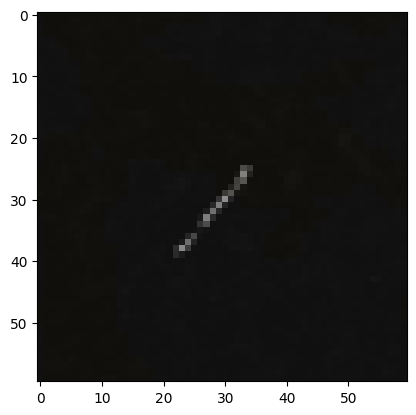

In [8]:
img_batch = train_ds.take(1)
batch_iterator = iter(img_batch)
image, label = next(batch_iterator)

plt.imshow(image[0].numpy().astype("uint8"))

# Wykres przedstawiający rozkład ilości obrazów na klasę

Pod uwagę wzięty został zbiór danych treningowych

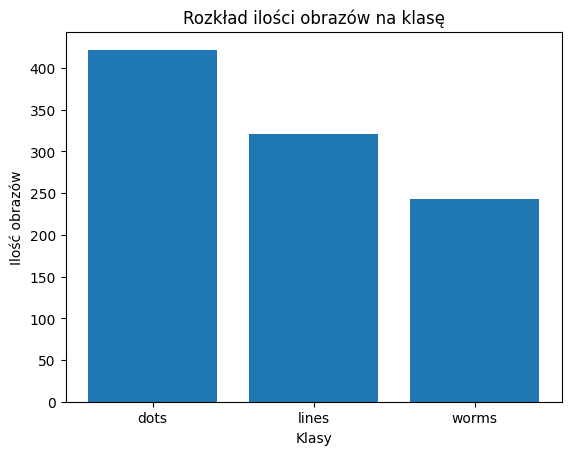

In [10]:
# Nazwy klas
class_names = train_ds.class_names

# Dla każdej nazwy klasy musimy mieć ilość sklasyfikowanych obrazow
class_members_count = {class_name: 0 for class_name in class_names}

for _, labels in train_ds:
  for label in labels.numpy():
    idx = np.where(label)[0][0]
    class_name = class_names[idx]
    class_members_count[class_name] += 1

plt.bar(class_members_count.keys(), class_members_count.values())
plt.xlabel('Klasy')
plt.ylabel('Ilość obrazów')
plt.title('Rozkład ilości obrazów na klasę')
plt.show()

# Preprocessing obrazów

Preprocessing jest na ten moment dokonywany w bardzo prosty aczkolwiek efektywny sposób. Każdy piksel obrazu jest podzielony przez 255 wskutek czego trafia on do zbioru wartości [0, 1].

Dzięki takiej operacji żadna cecha obrazu nie staje się ważniejsza podczas procesu trenowania modelu. W efekcie otrzymamy model, który będzie brał pod uwagę każdy piksel obrazu podczas jego przetwarzania.


In [11]:
preprocessed_images = []

for images, labels in train_ds:
  for image in images:
    processed_image = preprocess_image(image)
    preprocessed_images.append(processed_image)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(60, 60, 3), dtype=float32)


# Model sieci konwolucyjnej (CNN)

Sieć konwolucyjna będzie zdefiniowana w stylu tzw. **feature pyramid**. Oznacza to, że z każdą kolejną warstwą konwolucyjną przestrzeń obrazu będzie się zmniejszać natomiast zwiększać się będzie ilość kanałów.

W ten sposób wczesne warstwy będą wykrywać proste cechy obrazu takie jak na przykład krawędzie natomiast dalsze warstwy będą wykrywać coraz to bardziej skomplikowane i abstrakcyjne cechy.

Z każdą kolejną warstwą idąc głębiej w sieć "oddalamy się" od szczegółów poprzez zmniejszanie przestrzeni obrazu, lecz zwiększamy ilość wykrywanych cech co powinno dać pożądany, opisany powyżej efekt.

Model będzie składał się z warstw:


*   Conv2D
*   MaxPooling2D
*   FC (Fully Connected Network)







In [2]:
class CNNClasifier(tf.keras.Model):
  def __init__(self, num_filters=30):
    # Wywołanie konstruktora klasy nadrzędnej, czyli tf.keras.Model
    super().__init__()

    # Definicja warstw konwolucyjnych
    self.conv1 = tf.keras.layers.Conv2D(num_filters, # number of filters
                                        3, # kernel size
                                        activation='relu',
                                        kernel_initializer="he_normal")

    self.max_pool1 = tf.keras.layers.MaxPooling2D(strides=2)

    self.conv1 = tf.keras.layers.Conv2D(num_filters*3, # number of filters
                                        3, # kernel size
                                        activation='relu',
                                        kernel_initializer="he_normal")

    self.max_pool2 = tf.keras.layers.MaxPooling2D(strides=2)

    self.conv3 = tf.keras.layers.Conv2D(num_filters*3+num_filters, # number of filters
                                        3, # kernel size
                                        strides=(2,2),
                                        activation='relu',
                                        kernel_initializer="he_normal")

    # TO DO: Dodać warstwy typu Dense


/content


In [14]:
!cp ../drive/MyDrive/
!ls -l

cp: cannot stat '../drive/MyDrive/Colab': No such file or directory
cp: cannot stat 'Notebooks/credo_image_classifier.ipynb': No such file or directory
total 5764
-rw-r--r-- 1 root root  125581 Nov 12 20:05 credo_image_classifier.ipynb
drwx------ 5 root root    4096 Nov 12 20:08 images
-rw-r--r-- 1 root root 5757268 Nov 12 20:05 images.zip
drwxr-xr-x 2 root root    4096 Nov 12 20:08 __pycache__
-rw-r--r-- 1 root root      18 Nov 12 20:05 README.md
-rw-r--r-- 1 root root    1614 Nov 12 20:08 utils.py
